# **Communities Visualiztion**


## **Imports**


In [1]:
import os
import sys
from warnings import filterwarnings
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

%matplotlib inline
%load_ext autotime

load_dotenv()
filterwarnings("ignore")

module_path = os.path.abspath(os.path.join("../"))
parent_dir = os.path.dirname(os.getcwd())
if module_path not in sys.path:
    sys.path.append(module_path)

time: 2.66 ms (started: 2022-12-31 00:32:41 -05:00)


In [26]:
import tweepy
import numpy as np
import pandas as pd
import dask.dataframe as dd
import ast
from scipy.stats import gmean
import networkx as nx
import seaborn as sns
from utils.graph import get_ego_graph, draw_nx_graph, draw_plotly_graph

PATH = os.getcwd()
PROJECT = str(Path(PATH).parents[0])
TWITTER_USERNAME = os.getenv("TWITTER_USERNAME")
TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_API_BEARER_TOKEN = os.getenv("TWITTER_API_BEARER_TOKEN")
CLOUD_STORAGE_BUCKET = os.getenv("CLOUD_STORAGE_BUCKET")
TWITTER_USERNAME=os.getenv("TWITTER_USERNAME")
TWITTER_USER_ID=os.getenv("TWITTER_FOCAL_NODE_ID")

client = tweepy.Client(TWITTER_API_BEARER_TOKEN, wait_on_rate_limit=True)

time: 1.77 ms (started: 2022-12-31 00:42:51 -05:00)


## **Read**


### **Node Centrality (Subset)**


In [3]:
df_cen = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/measures/node/node_measures.csv").compute()
print(df_cen.shape)
df_cen.head()

(1117046, 3)


,measure_name,node,measure_value
0,pagerank,44196397,0.000015
1,pagerank,433365936,0.000012
2,pagerank,2248872301,0.000012
3,pagerank,35761106,0.000012
4,pagerank,1542483269542940679,0.000012


time: 9.8 s (started: 2022-12-31 00:32:54 -05:00)


### **Node Features**


In [4]:
nodes = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/features/node/node_features*.csv", dtype={'withheld': 'object'}).compute()
print(nodes.shape)
nodes.head()

(206084, 7)


,id,name,profile_image_url,public_metrics,username,verified,withheld
0,794433401591693312,Aran Komatsuzaki,https://pbs.twimg.com/profile_images/150798283...,"{'followers_count': 16111, 'following_count': ...",arankomatsuzaki,False,NaN
1,2509504696,Jericho Brown,https://pbs.twimg.com/profile_images/111968593...,"{'followers_count': 40468, 'following_count': ...",jerichobrown,True,NaN
2,1938030980,Angel Wicky,https://pbs.twimg.com/profile_images/144139505...,"{'followers_count': 355162, 'following_count':...",Angel_Wicky_II,True,NaN
3,335544910,AC Justice Project,https://pbs.twimg.com/profile_images/145415812...,"{'followers_count': 1049, 'following_count': 4...",ACJProject,False,NaN
4,2622261,Brian Ulicny,https://pbs.twimg.com/profile_images/730781652...,"{'followers_count': 796, 'following_count': 24...",bulicny,False,NaN


time: 18.8 s (started: 2022-12-31 00:33:03 -05:00)


### **Graph**


In [5]:
df = dd.read_csv(f"{CLOUD_STORAGE_BUCKET}/ties/ties*.csv").compute()
df.following = df.following.apply(ast.literal_eval)
df = df.explode('following')

#if you need a full graph including the user
user = client.get_user(
    username=TWITTER_USERNAME,
    user_fields=["id"],
).data.id
df_following = df.copy().dropna()
df_user = pd.DataFrame({"user": user, "following": df_following.user.unique()})
df_with_user = pd.concat([df_user, df_following])

#create  a graph
edges = df_with_user.copy().dropna()
edges.columns = ['source', 'target']
edges['source'] = edges['source'].astype(int)
edges['target'] = edges['target'].astype(int)
edges['weight'] = 1
print(df.shape, edges.shape)

G = nx.from_pandas_edgelist(
    edges,
    create_using=nx.DiGraph(),
    edge_attr=True
)
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")
df.head()

(239795, 2) (240033, 3)
Nodes: 159578, Edges: 237327


,user,following
0,12,69170362
0,12,1499167615121387522
0,12,594103
0,12,58868301
0,12,721049861399949313


time: 5.45 s (started: 2022-12-31 00:33:22 -05:00)


In [18]:
c_s = list(nx.strongly_connected_components(G))
c_s.sort(key=len, reverse=True)

time: 964 ms (started: 2022-12-31 00:38:04 -05:00)


## **Ego Graph**

In [61]:
G_s, _, _ = get_ego_graph(G, node=user)
dangler_nodes = [node for node, degree in dict(G_s.degree()).items() if degree <= 1]
G_s.remove_nodes_from(dangler_nodes)

node_labels_dict = dict(zip(nodes['id'], nodes['name']))
nx.set_node_attributes(G_s, node_labels_dict, "name")
node_labels = list(nx.get_node_attributes(G_s, "name").values())

print(f"{user}")
print(f"Nodes: {len(G_s.nodes())}, Edges: {len(G_s.edges())}")
# draw_nx_graph(G_s, fig_size  = (20, 20), font_size = 10, node_size = 500, linewidths = 3, width = 0.5, alpha = 0.8)
# draw_plotly_graph(G_s.to_directed(), node_labels=node_labels,node_colors='default', title='Twitter Ego Network')

1427408443296657408
Nodes: 242, Edges: 4307
time: 459 ms (started: 2022-12-06 20:15:28 -05:00)


## **Communities (Ego)**

In [79]:
from community import community_louvain, generate_dendrogram, best_partition, induced_graph, modularity, partition_at_level
community_dict = community_louvain.best_partition(G_s.to_undirected(), random_state=42)
n_communities = pd.Series(community_dict.values()).nunique()
print(f"Communities at best partition: {n_communities}")

nx.set_node_attributes(G_s, community_dict, "community")
node_community_map = list(nx.get_node_attributes(G_s, "community").values())

G_part = best_partition(G_s.to_undirected(), random_state= 42)
G_s_c = induced_graph(G_part, G_s.to_undirected())
print(modularity(G_part, G_s.to_undirected()))

scale_factor = 100
threshold = 25
e_weights_data = pd.DataFrame(nx.get_edge_attributes(G_s_c, "weight"), index=[0]).T
e_weights_data.columns = ['weight']
e_weights_data=e_weights_data.reset_index()
e_weights_data['total_weight'] = e_weights_data.groupby('level_0').weight.transform('sum')
e_weights_data['weight'] = np.power(e_weights_data['weight']/e_weights_data['total_weight'], 1)
e_weights_data['weight'] = scale_factor*(e_weights_data['weight']/e_weights_data['weight'].max())
edge_weights = list(e_weights_data.weight)
e_weights_data

Communities at best partition: 4
0.299706442799879


,level_0,level_1,weight,total_weight
0,0,3,25.144509,692
1,0,1,23.121387,692
2,0,0,42.052023,692
3,0,2,9.682081,692
4,1,1,48.428405,1718
5,1,3,24.097788,1718
6,1,2,27.473807,1718
7,3,3,76.809651,746
8,3,2,23.190349,746
9,2,2,100.000000,348


time: 307 ms (started: 2022-12-06 20:33:13 -05:00)


In [132]:
cols = ['community', 'name','username', 'public_metrics']
nodes_ego = pd.DataFrame.from_dict(dict(G_s.nodes(data=True)), orient='index')
nodes_ego = nodes_ego[[cols[0]]].merge(nodes.set_index('id')[cols[1:]], left_index=True, right_index=True)
nodes_ego = nodes_ego.merge(nodes_ego.public_metrics.map(eval).apply(pd.Series), left_index=True, right_index=True ).drop(columns=['public_metrics']).drop_duplicates()
nodes_ego['rep_measure'] = np.power(np.log((nodes_ego['followers_count']/(0.1+nodes_ego['following_count'])))*nodes_ego['listed_count'], 0.5)

# nodes_ego.sort_values(by='rep_measure', ascending = False).head(20)
nodes_ego_rep = nodes_ego.set_index('name').groupby('community')['rep_measure'].nlargest(1).reset_index()
nodes_ego_rep = nodes_ego_rep.merge(nodes_ego.groupby('community')['tweet_count'].median(), left_index=True, right_index=True )
nodes_ego_rep = pd.DataFrame(list(G_s_c.nodes()), columns=['community']).merge(nodes_ego_rep, on=['community'])
nodes_ego_rep

,community,name,rep_measure,tweet_count
0,0,Anonymous,392.881170,638.0
1,1,J.K. Rowling,562.578136,9612.0
2,3,NASA,1113.210331,2742.5
3,2,Donald J. Trump,1273.155987,14823.0


time: 377 ms (started: 2022-12-06 21:05:54 -05:00)


In [133]:
source, target, weight = [], [], []
for node1, node2, data in G_s.edges(data=True):
    source.append(node1)
    target.append(node2)
    weight.append(data['weight'])

time: 9.8 ms (started: 2022-12-06 21:06:45 -05:00)


### D3

In [134]:
# Import library
from d3graph import d3graph, vec2adjmat

# Initialize
d3 = d3graph()
adjmat = vec2adjmat(source, target, weight=weight)

d3.graph(adjmat)
# d3.set_node_properties(label=nodes_ego_rep['name'].values, color=nodes_ego_rep['name'].values, size=nodes_ego_rep['tweet_count'].values)

# Write to specified directory with custom filename
d3.show()

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 242
[d3graph] INFO> Slider range is set to [0, 1]
[d3graph] INFO> Write to path: [/tmp/tmp27vs5co5/d3graph.html]


time: 1.85 s (started: 2022-12-06 21:06:46 -05:00)


## **Communities**

### Louvian

In [6]:
from community import community_louvain, generate_dendrogram, best_partition, induced_graph, modularity, partition_at_level
community_dict = community_louvain.best_partition(G.to_undirected(), random_state=42)
n_communities = pd.Series(community_dict.values()).nunique()
print(f"Communities at best partition: {n_communities}")
custom_colors = ['rgb(44,105,176)',
                 'rgb(240,39,32)',
                 'rgb(172,97,60)',
                 'rgb(107,163,214)',
                 'rgb(234,107,115)',
                 'rgb(65,68,81)'
                ]

custom_colors = np.resize(custom_colors, n_communities)

Communities at best partition: 32
time: 10.4 s (started: 2022-12-04 17:44:52 -05:00)


In [7]:
nx.set_node_attributes(G, community_dict, "community")
node_community_map = list(nx.get_node_attributes(G, "community").values())
node_colors = [custom_colors[x] for x in node_community_map]

time: 377 ms (started: 2022-12-04 17:45:29 -05:00)


In [8]:
G_den = generate_dendrogram(G.to_undirected())
G_den = partition_at_level(G_den, len(G_den)-1)

G_part = best_partition(G.to_undirected(), random_state= 42)
G_s_c = induced_graph(G_part, G.to_undirected())
print(modularity(G_part, G.to_undirected()))

0.7354019762638058
time: 27.1 s (started: 2022-12-04 17:45:46 -05:00)


In [9]:
# nodes_exp = nodes.copy()
# nodes_exp['community'] = nodes_exp['id'].apply(lambda x: G_part.get(x))
# TWITTER_NAME = nodes_exp[nodes_exp.username==TWITTER_USERNAME].name.unique()[0]
# nodes_exp['name'] = nodes_exp['name'].apply(lambda x: "<obf: name>" if x==TWITTER_NAME else str(x).lower())

# for n in range(n_communities):
#     print(f"\ncommunity {n}:")
#     comm_node_names = nodes_exp[nodes_exp.community==n].sort_values(by=['followers_count','tweet_count'], ascending=False).name.tolist()
#     print(*comm_node_names,sep='\n')

time: 761 µs (started: 2022-12-04 17:46:20 -05:00)


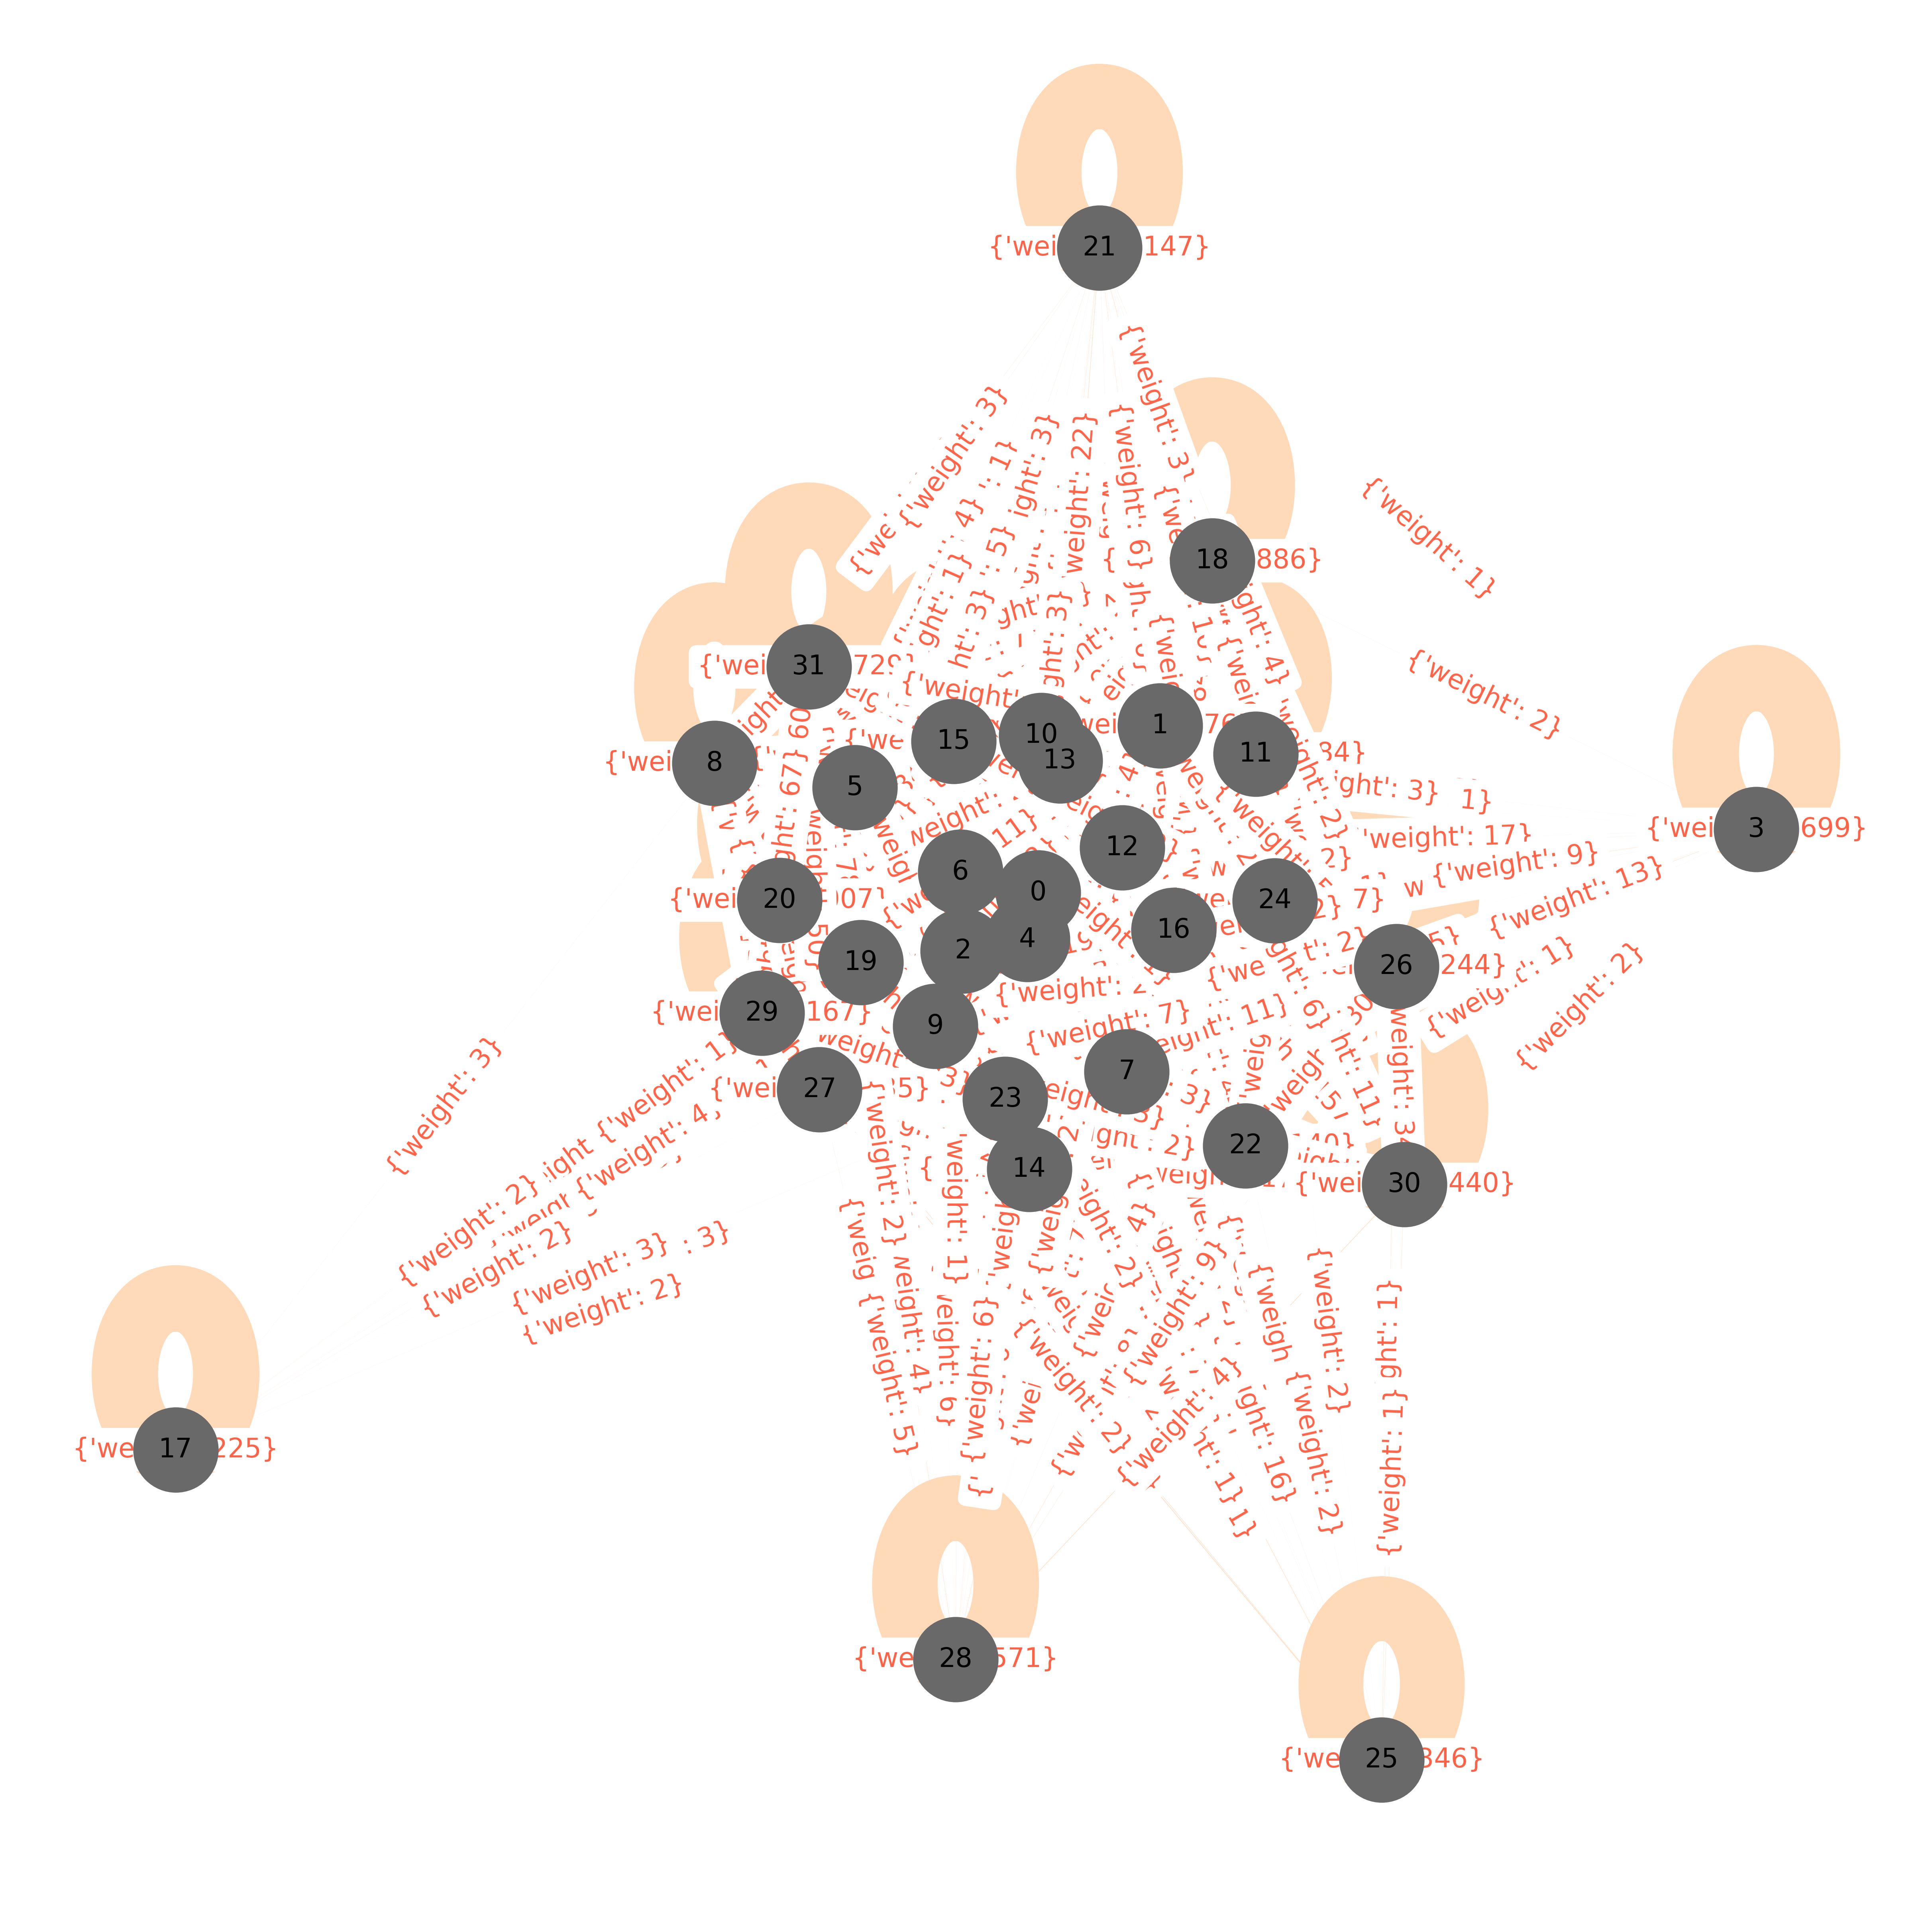

time: 5.96 s (started: 2022-12-04 17:48:11 -05:00)


In [12]:
scale_factor = 50
e_weights_data = pd.DataFrame(nx.get_edge_attributes(G_s_c, "weight"), index=[0]).T
e_weights_data.columns = ['weight']
e_weights_data=e_weights_data.reset_index()
e_weights_data['total_weight'] = e_weights_data.groupby('level_0').weight.transform('sum')
e_weights_data['weight'] = np.power(e_weights_data['weight']/e_weights_data['total_weight'], 1)
e_weights_data['weight'] = scale_factor*(e_weights_data['weight']/e_weights_data['weight'].max())
edge_weights = list(e_weights_data.weight)

# comm_labels = {0: 'misc', 1: 'ai', 2: 'political_outcasts', 3: 'space_cowboys', 4: 'spread_the_love_authors'}
# G_s_c_rl = nx.relabel_nodes(G_s_c, comm_labels, copy=True)

draw_nx_graph(G_s_c, node_labels=True, width =  edge_weights, node_label_font_color = 'black', node_size = 4000, font_size = 20, alpha=1)

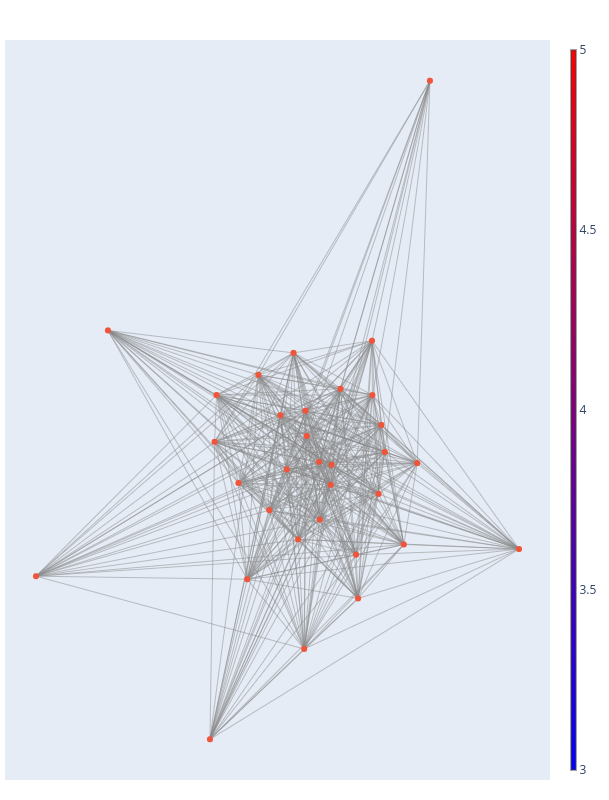

time: 70.5 ms (started: 2022-12-04 17:49:46 -05:00)


In [15]:
draw_plotly_graph(G_s_c)#, node_colors = list(custom_colors), node_sizes = 20

### Async Fluid Communities

In [40]:
community_dict_fluid = list(nx.algorithms.community.asyn_fluidc(G.to_undirected(), k=10, max_iter=100, seed=42))
n_communities = len(community_dict_fluid)
print(f"Communities at best partition: {n_communities}")

Communities at best partition: 10
time: 22.9 s (started: 2022-12-04 18:22:57 -05:00)


In [56]:
G_part_fluid = {}
for i, v in enumerate(community_dict_fluid):
    for j in v:
        G_part_fluid[j] = i
G_c = induced_graph(G_part_fluid, G.to_undirected())
print(modularity(G_part_fluid, G.to_undirected()))

0.6075381439204909
time: 6.46 s (started: 2022-12-04 18:59:08 -05:00)


In [45]:
def set_node_community(G, communities):
        '''Add community to node attributes'''
        for c, v_c in enumerate(communities):
            for v in v_c:
                # Add 1 to save 0 for external edges
                G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

time: 3.68 ms (started: 2022-12-04 18:25:00 -05:00)


In [88]:
_ = []
for i in list(G_c.nodes()):
    _.append({i})
_

[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}]

time: 8.9 ms (started: 2022-12-04 19:06:36 -05:00)


In [89]:
H = G_c.copy()
community_dict_fluid = [{i} for i in list(G_c.nodes())]
# Set node and edge communities
set_node_community(H, community_dict_fluid)
set_edge_community(H)
node_color = [get_color(H.nodes[v]['community']) for v in H.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in H.edges if H.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in H.edges if H.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

time: 32.6 ms (started: 2022-12-04 19:07:16 -05:00)


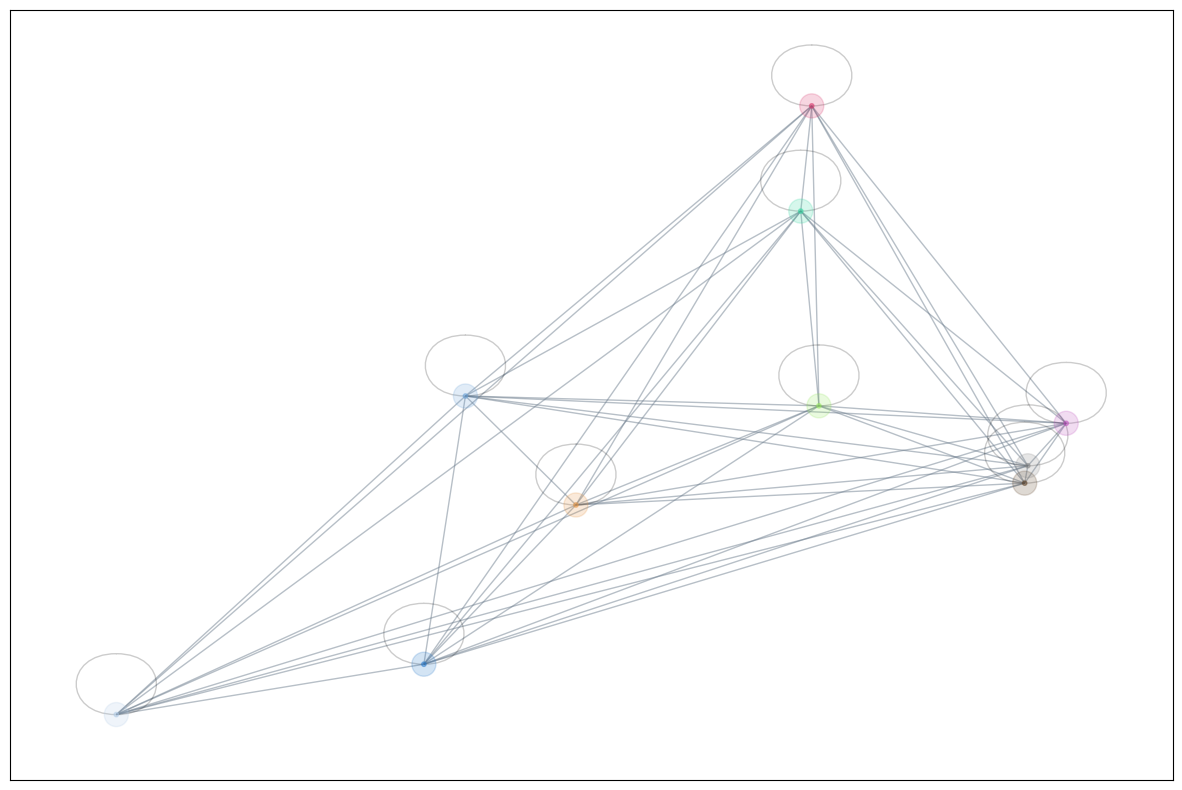

time: 329 ms (started: 2022-12-04 19:14:48 -05:00)


In [104]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (15, 10)})
# plt.style.use('dark_background')
pos = nx.spring_layout(H, k=0.0001)
# external edges
nx.draw_networkx(
    H,
    pos=pos,
    node_size=10,
    edgelist=external,
    edge_color="slategrey",
    node_color=node_color,
    alpha=0.5,
    with_labels=False)
# internal edges
nx.draw_networkx(
    H, pos=pos,
    edgelist=internal,
    edge_color=internal_color,
    node_color=node_color,
    alpha=0.2,
    with_labels=False)

In [132]:
node_color_plotly = []
for i,v in enumerate(node_color):
    t =  () + (0.5,)
    v_t = v + t
    node_color_plotly.append(f'rgba{v_t}')

time: 1.25 ms (started: 2022-12-04 19:27:01 -05:00)


In [153]:
import networkx as nx
import plotly.graph_objects as go
def draw_plotly_graphx(
    graph=None,
    edge_labels=None,
    node_labels=None,
    pos=None,
    node_colors=None,
    node_sizes=None,
    write_html=False,
    title=None,
    fig_size_px=(800, 800),
    hide_color_axis=True,
):
    edge_x = []
    edge_y = []
    widths = []
    pos = nx.spring_layout(graph, threshold=1e-4, iterations=100)
    pos=nx.rescale_layout_dict(pos)
    c_ev = nx.eigenvector_centrality(graph)
    edge_trace =  [dict(type='scatter',
                   x=[pos[e[0]][0], pos[e[1]][0], None],
                   y=[pos[e[0]][1], pos[e[1]][1], None],
                   mode='lines',
                   line=dict(width=0.5, color="#888",smoothing=0.2,simplify=True,shape="spline")) for e in graph.edges(data=True)]

    node_x = []
    node_y = []
    for node in graph.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        marker=dict(
            # showscale=True,
            colorscale="YlOrRd",
            reversescale=False,
            color=[],
            size=10,
            # colorbar=dict(thickness=5, xanchor="left", titleside="right"),
            line_width=0.0,
        ),
    )

    # color nodes
    if node_labels:
        _node_labels = node_labels
    else:
        node_adjacencies = []
        _node_labels = []
        for node, adjacencies in enumerate(graph.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            _node_labels.append(
                "adjacent connections: " + str(len(adjacencies[1]))
            )
    node_trace.text = _node_labels

    if node_colors == "default":
        _node_colors = [1e2 * x for x in list(c_ev.values())]
    else:
        _node_colors = node_colors
    node_trace.marker.color = _node_colors

    if node_sizes == "default":
        _node_sizes = [1e2 * x for x in list(c_ev.values())]
    else:
        _node_sizes = node_sizes
    node_trace.marker.size = _node_sizes

    # create plot
    fig = go.Figure(
        # data=[edge_trace, node_trace],
        data = edge_trace+[node_trace],
        layout=go.Layout(
            title={
                "text": title,
                "font_size": 16,
                "x": 0.5,
                "xanchor": "center",
                "yanchor": "top",  # new
            },
            showlegend=False,
            hovermode="closest",
            margin=dict(b=20, l=5, r=5, t=40),
            width=fig_size_px[0],
            height=fig_size_px[1],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        ),
    )
    fig.update_layout(plot_bgcolor = "white")
    if hide_color_axis:
        fig.update_coloraxes(showscale=False)

    if write_html:
        fig.write_html("first_degree_test.html", auto_open=True)
    return fig

time: 6.64 ms (started: 2022-12-04 19:35:11 -05:00)


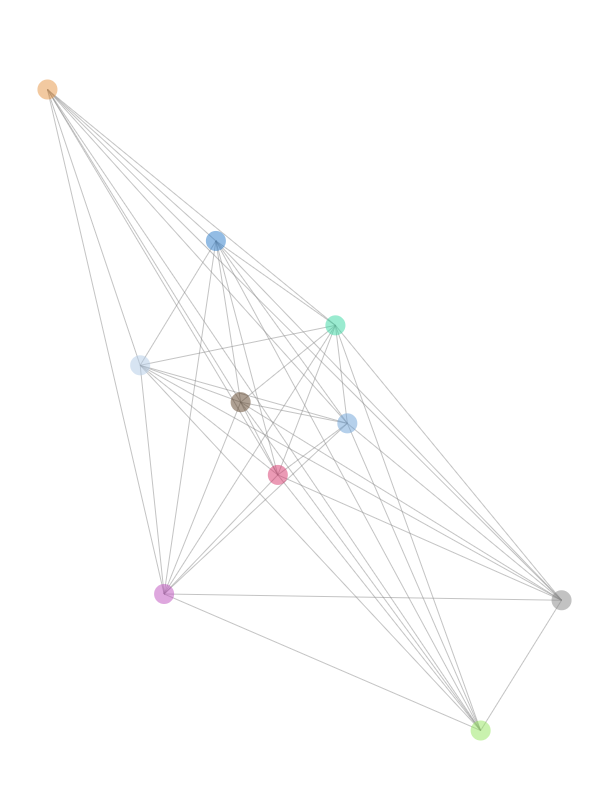

time: 115 ms (started: 2022-12-04 19:35:20 -05:00)


In [154]:
fig = draw_plotly_graphx(H, pos=pos, node_colors =node_color_plotly, node_sizes = 20)
fig.show()